## Read labels json and print all unique ones

Ελέγξτε πόσες και ποιες κατηγορίες είναι διαθέσιμες στο υποσύνολο δεδομένων της άσκησης. Ορίστε νέο indexing για τις κατηγορίες

In [1]:
import json
from collections import Counter
import os
# import pickle as pkl
import shutil
import numpy as np
from torchvision.transforms import transforms
import torch
from utils import RandomSamplePixels, Normalize, ToTensor,\
    PixelSetData, split_dict_train_test, pad_sequences_collate_fn
from torch.utils.data import DataLoader

# labels of zarr files according to original labels.json
f_labels = open(r"Exercise4\timematch_data\denmark\32VNH\2017\meta\labels.json")
labels_json_original = json.load(f_labels)

print(len(labels_json_original.keys()))
print(len(set(labels_json_original.values())))

5001
14


Οι διαθέσιμες  κατηγορίες στα δικά μας αρχικά δεδομένα είναι 14

In [2]:
unique_labels = set()
for val in labels_json_original.values():
    unique_labels.add(val)

labels_counter = Counter(labels_json_original.values())

for lab in unique_labels:
    print(lab, labels_counter[lab])

spring_peas 17
spring_oat 120
spring_wheat 26
winter_barley 352
winter_rye 317
horsebeans 28
spring_triticale 2
unknown 511
corn 275
winter_triticale 42
spring_barley 1141
winter_wheat 856
meadow 1013
winter_rapeseed 301


Τα δεδομένα κατηγοριών με λιγότερα από 200 δείγματα φεύγουν

In [3]:
def move_zarr_files_based_on_label(label_occurrences, zarr_folder_path, json_file_path, destination_folder_path):
    # Load the JSON file
    with open(json_file_path, 'r') as json_file:
        labels = json.load(json_file)
    
    # Ensure the destination folder exists
    os.makedirs(destination_folder_path, exist_ok=True)

    # Iterate over the zarr files in the given folder
    for file_name in os.listdir(zarr_folder_path):
        if file_name.endswith('.zarr'):
            file_number = file_name.replace('.zarr', '')
            
            # Check if the file number is in the labels dictionary
            if file_number in labels:
                label = labels[file_number]
                
                # Check if the occurrence of the label is less than 200
                if label_occurrences.get(label, 0) < 200:
                    source_path = os.path.join(zarr_folder_path, file_name)
                    destination_path = os.path.join(destination_folder_path, file_name)
                    
                    shutil.move(source_path, destination_path)
                    print(f"Moved {file_name} to {destination_folder_path}")

# move_zarr_files_based_on_label(
#     labels_counter, "Exercise4/timematch_data/denmark/32VNH/2017/data",
#     r"C:\Users\Yannis\Downloads\edemm_earino\gewxwrika\proj3\Exercise4\timematch_data\denmark\32VNH\2017\meta\labels.json",
#     "moved_zarrs")

print(len(os.listdir("moved_zarrs")))

235


Φεύγουν και τα δείγματα άγνωστων κατηγοριών

In [4]:
def move_unknown_zarr(zarr_folder_path, json_file_path, destination_folder_path):
    with open(json_file_path, 'r') as json_file:
        labels = json.load(json_file)
    
    os.makedirs(destination_folder_path, exist_ok=True)

    # Iterate over the zarr files in the given folder
    for file_name in os.listdir(zarr_folder_path):
        if file_name.endswith('.zarr'):
            file_number = file_name.replace('.zarr', '')

            # Check if the file number is in the labels dictionary
            if file_number in labels:
                label = labels[file_number]

                if label == 'unknown':
                    source_path = os.path.join(zarr_folder_path, file_name)
                    destination_path = os.path.join(destination_folder_path, file_name)
                    
                    shutil.move(source_path, destination_path)
                    print(f"Moved {file_name} to {destination_folder_path}")

# move_unknown_zarr(
#     "Exercise4/timematch_data/denmark/32VNH/2017/data",
#     r"C:\Users\Yannis\Downloads\edemm_earino\gewxwrika\proj3\Exercise4\timematch_data\denmark\32VNH\2017\meta\labels.json",
#     "moved_unknowns")

print(len(os.listdir("moved_unknowns")))

511


Καινούριο dict από labels με τα δείγματα που έχουν απομείνει

In [5]:
# labels_200 will contain the labels with more than 200 occurrences
labels_200 = {}

for file_name in os.listdir("Exercise4/timematch_data/denmark/32VNH/2017/data"):
    if file_name.endswith('.zarr'):
        file_number = file_name.replace('.zarr', '')
        
        # if the number of occurrences of label is greater than 200,
        # add it to the labels_200 dictionary
        category = labels_json_original[file_number]
        if labels_counter[category] > 200:
            labels_200[file_number] = labels_json_original[file_number]

# labels_200 = dict(sorted(labels_200.items()))
print(len(labels_200))

count = 0
for lab in labels_200:
    print(lab, labels_200[lab])
    count += 1
    if count == 7:
        break

labels_200_counter = Counter(labels_200.values())

print()

for lab in labels_200_counter:
    print(lab, labels_200_counter[lab])

4255
0 corn
1 corn
10 corn
100 winter_rapeseed
1000 spring_barley
1001 winter_rye
1002 spring_barley

corn 275
winter_rapeseed 301
spring_barley 1141
winter_rye 317
winter_barley 352
winter_wheat 856
meadow 1013


Αποθήκευση σε καινούριο json αρχείο

In [6]:
# # save the labels_200 dictionary to a json file in descending order of keys
# # the keys are ints as strings, so they will be sorted in the correct order

# labels_200 = dict(sorted(labels_200.items(), key=lambda item: int(item[0])))

# with open(r"Exercise4\timematch_data\denmark\32VNH\2017\meta\labels_cleaned.json", 'w') as f:
#     json.dump(labels_200, f)

Αντιστοίχιση τελικών labels με αριθμητικά indices

In [7]:
class_to_idx = {cls: idx for idx, cls in enumerate(labels_200_counter)}

for key, val in class_to_idx.items():
    print(key, val, type(val))

corn 0 <class 'int'>
winter_rapeseed 1 <class 'int'>
spring_barley 2 <class 'int'>
winter_rye 3 <class 'int'>
winter_barley 4 <class 'int'>
winter_wheat 5 <class 'int'>
meadow 6 <class 'int'>


To labels_200 περιέχει πλέον όλα τα keys που έχουμε κρατήσει μαζί με τα ανανεωμένα τους labels. Θα το χρησιμοποιήσουμε για να χωρίσουμε train και test δεδομένα

In [8]:
train_labels, val_labels = split_dict_train_test(labels_200, test_size=0.2)

print(len(labels_200))
print(len(train_labels))
print(len(val_labels))

4255
3400
855


In [9]:
for lab in labels_200_counter:
    print(lab, labels_200_counter[lab])

print()

count = 0
for lab in train_labels:
    print(lab, train_labels[lab])
    count += 1
    if count == 7:
        break
print()
train_labels_counter = Counter(train_labels.values())
for lab in train_labels_counter:
    print(lab, train_labels_counter[lab])

print()

count = 0
for lab in val_labels:
    print(lab, val_labels[lab])
    count += 1
    if count == 7:
        break
print()
val_labels_counter = Counter(val_labels.values())
for lab in val_labels_counter:
    print(lab, val_labels_counter[lab])

corn 275
winter_rapeseed 301
spring_barley 1141
winter_rye 317
winter_barley 352
winter_wheat 856
meadow 1013

13 corn
888 corn
899 corn
1570 corn
690 corn
3524 corn
2900 corn

corn 220
winter_rapeseed 240
spring_barley 912
winter_rye 253
winter_barley 281
winter_wheat 684
meadow 810

153 corn
3436 corn
4854 corn
336 corn
636 corn
711 corn
877 corn

corn 55
winter_rapeseed 61
spring_barley 229
winter_rye 64
winter_barley 71
winter_wheat 172
meadow 203


## Define train and test dataset

In [10]:
train_transform = transforms.Compose([
        RandomSamplePixels(32),
        Normalize(), ToTensor(),
    ])

test_transform = transforms.Compose([
        Normalize(), ToTensor(),
    ])

train_dataset = PixelSetData("Exercise4/timematch_data/denmark/32VNH/2017",
                             class_to_idx,
                             train_labels,
                             train_transform)
print()
print(len(train_dataset))


val_dataset = PixelSetData("Exercise4/timematch_data/denmark/32VNH/2017",
                             class_to_idx,
                             val_labels,
                             test_transform)
print()
print(len(val_dataset))

('Exercise4/timematch_data/denmark/32VNH/2017\\data\\0.zarr', '0', 'corn')
('Exercise4/timematch_data/denmark/32VNH/2017\\data\\1.zarr', '1', 'corn')
('Exercise4/timematch_data/denmark/32VNH/2017\\data\\10.zarr', '10', 'corn')
('Exercise4/timematch_data/denmark/32VNH/2017\\data\\100.zarr', '100', 'winter_rapeseed')
('Exercise4/timematch_data/denmark/32VNH/2017\\data\\1000.zarr', '1000', 'spring_barley')
('Exercise4/timematch_data/denmark/32VNH/2017\\data\\1001.zarr', '1001', 'winter_rye')

3400
('Exercise4/timematch_data/denmark/32VNH/2017\\data\\1023.zarr', '1023', 'meadow')
('Exercise4/timematch_data/denmark/32VNH/2017\\data\\1024.zarr', '1024', 'winter_rye')
('Exercise4/timematch_data/denmark/32VNH/2017\\data\\1029.zarr', '1029', 'winter_wheat')
('Exercise4/timematch_data/denmark/32VNH/2017\\data\\1034.zarr', '1034', 'spring_barley')
('Exercise4/timematch_data/denmark/32VNH/2017\\data\\1039.zarr', '1039', 'winter_barley')
('Exercise4/timematch_data/denmark/32VNH/2017\\data\\1040.zar

In [11]:
# print(train_dataset[0])

In [12]:
def display_sample(sample):
    for k, v in sample.items():
        if isinstance(v, torch.Tensor):
            print(k, type(v), v.shape)
        else:
            print(k, type(v), v)
    print(np.unique(sample['valid_pixels']))

In [13]:
display_sample(train_dataset[10])
print()
display_sample(train_dataset[1301])

index <class 'int'> 10
pixels <class 'torch.Tensor'> torch.Size([52, 10, 32])
valid_pixels <class 'torch.Tensor'> torch.Size([52, 32])
label <class 'str'> winter_wheat
label_idx <class 'int'> 5
[1.]

index <class 'int'> 1301
pixels <class 'torch.Tensor'> torch.Size([52, 10, 32])
valid_pixels <class 'torch.Tensor'> torch.Size([52, 32])
label <class 'str'> meadow
label_idx <class 'int'> 6
[1.]


In [14]:
display_sample(val_dataset[10])
print()
display_sample(val_dataset[854])

index <class 'int'> 10
pixels <class 'torch.Tensor'> torch.Size([52, 10, 221])
valid_pixels <class 'torch.Tensor'> torch.Size([52, 221])
label <class 'str'> spring_barley
label_idx <class 'int'> 2
[1.]

index <class 'int'> 854
pixels <class 'torch.Tensor'> torch.Size([52, 10, 491])
valid_pixels <class 'torch.Tensor'> torch.Size([52, 491])
label <class 'str'> winter_wheat
label_idx <class 'int'> 5
[1.]


## Dataloader

In [15]:
# # from torch.nn.utils.rnn import pad_sequence
# # def pad_sequences_collate_fn(samples: List[tuple]) -> tuple:
# #     """
# #     Zero-pad (in front) each sample to enable batching. The longest
# #     sequence defines the sequence length for the batch
# #     """
# #     labels = torch.stack([torch.tensor(v['label_idx']) for v in samples])
# #     data = pad_sequence([v['pixels'] for v in samples], batch_first=True)
# #     key_mask = pad_sequence(
# #         # last dimension is the sequence length
# #         [torch.zeros(v['pixels'].shape[-1], dtype=torch.bool) for v in samples],
# #         padding_value=True,
# #         batch_first=True,
# #     )
# #     return data, labels, key_mask

# from typing import List
# def pad_sequences_collate_fn(samples: List[dict]) -> tuple:
#     """
#     Zero-pad (in front) each sample to enable batching. The longest
#     sequence defines the sequence length for the batch.
#     """
#     # Extract labels
#     labels = torch.tensor([v['label_idx'] for v in samples])
    
#     # Find the maximum sequence length in the batch
#     max_len = max(v['pixels'].shape[-1] for v in samples)
    
#     # Pad sequences and create padding masks
#     padded_pixels = []
#     padding_masks = []
#     for sample in samples:
#         pixels = sample['pixels']  # Shape: [52, 10, SIZES]
#         seq_len = pixels.shape[-1]
#         pad_len = max_len - seq_len
        
#         # Pad with zeros at the beginning of the last dimension
#         padded_pixel = torch.nn.functional.pad(pixels, (pad_len, 0))
#         padded_pixels.append(padded_pixel)
        
#         # Create the padding mask
        
#         # padding_mask = torch.zeros(max_len, dtype=torch.bool)
#         # padding_mask = torch.zeros((pixels.shape[0], pixels.shape[1], max_len), dtype=torch.bool)
#         padding_mask = torch.zeros((pixels.shape[0], max_len), dtype=torch.bool)
        
#         # padding_mask[:pad_len] = True
#         # padding_mask[:, :, :pad_len] = True
#         padding_mask[:, :pad_len] = True
        
#         padding_masks.append(padding_mask)
    
#     # Stack the padded pixels and masks
#     data = torch.stack(padded_pixels, dim=0)
#     key_mask = torch.stack(padding_masks, dim=0)

#     return data, labels, key_mask

What if I don't use collate_fn

In [16]:
train_dloader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    # collate_fn=pad_sequences_collate_fn,
    # num_workers=4,
)

print(len(train_dloader))

counter = 0
for batch in train_dloader:
    print(batch)
    
    counter += 1
    if counter == 1:
        break

425
{'index': tensor([ 676,  516,  538, 1599,  693, 2926,  815, 3004]), 'pixels': tensor([[[[0.0465, 0.0477, 0.0461,  ..., 0.0483, 0.0451, 0.0483],
          [0.0373, 0.0389, 0.0376,  ..., 0.0396, 0.0345, 0.0379],
          [0.0382, 0.0409, 0.0379,  ..., 0.0409, 0.0346, 0.0399],
          ...,
          [0.0779, 0.0755, 0.0780,  ..., 0.0780, 0.0611, 0.0774],
          [0.0154, 0.0141, 0.0155,  ..., 0.0153, 0.0113, 0.0152],
          [0.0110, 0.0106, 0.0111,  ..., 0.0114, 0.0090, 0.0113]],

         [[0.0194, 0.0198, 0.0194,  ..., 0.0208, 0.0193, 0.0206],
          [0.0149, 0.0154, 0.0147,  ..., 0.0167, 0.0147, 0.0168],
          [0.0129, 0.0134, 0.0123,  ..., 0.0158, 0.0129, 0.0159],
          ...,
          [0.0271, 0.0284, 0.0286,  ..., 0.0381, 0.0275, 0.0387],
          [0.0184, 0.0194, 0.0181,  ..., 0.0267, 0.0184, 0.0270],
          [0.0103, 0.0106, 0.0106,  ..., 0.0162, 0.0103, 0.0163]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000,

In [17]:
train_dloader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=pad_sequences_collate_fn,
    # num_workers=4,
)

print(len(train_dloader))

print()

counter = 0
for batch in train_dloader:
    # print(type(batch))
    # print(len(batch))
    # print(type(batch[0]))
    # print(type(batch[1]))
    # print(type(batch[2]))
    
    print(batch[0].shape)
    print(batch[1].shape)
    print(batch[1])
    print(batch[2].shape)
    print(np.unique(batch[2]))
    print()
    
    counter += 1
    if counter == 4:
        break

425

torch.Size([8, 52, 10, 32])
torch.Size([8])
tensor([6, 6, 4, 4, 5, 0, 6, 3])
torch.Size([8, 52, 32])
[False]

torch.Size([8, 52, 10, 32])
torch.Size([8])
tensor([6, 5, 1, 5, 2, 6, 5, 1])
torch.Size([8, 52, 32])
[False]

torch.Size([8, 52, 10, 32])
torch.Size([8])
tensor([6, 2, 6, 6, 2, 4, 4, 2])
torch.Size([8, 52, 32])
[False]

torch.Size([8, 52, 10, 32])
torch.Size([8])
tensor([3, 1, 6, 6, 1, 4, 5, 0])
torch.Size([8, 52, 32])
[False]



In [18]:
val_dloader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=pad_sequences_collate_fn,
    # num_workers=4,
)

print(len(val_dloader))

print()

counter = 0
for batch in val_dloader:
    
    print(batch[0].shape)
    print(batch[1].shape)
    print(batch[1])
    print(batch[2].shape)
    print(np.unique(batch[2]))
    print()

    counter += 1
    if counter == 4:
        break

107

torch.Size([8, 52, 10, 691])
torch.Size([8])
tensor([2, 2, 5, 2, 6, 6, 2, 2])
torch.Size([8, 52, 691])
[False  True]

torch.Size([8, 52, 10, 885])
torch.Size([8])
tensor([2, 2, 2, 4, 5, 5, 1, 5])
torch.Size([8, 52, 885])
[False  True]

torch.Size([8, 52, 10, 1322])
torch.Size([8])
tensor([6, 6, 3, 3, 6, 4, 4, 5])
torch.Size([8, 52, 1322])
[False  True]

torch.Size([8, 52, 10, 1009])
torch.Size([8])
tensor([6, 2, 5, 5, 1, 4, 0, 2])
torch.Size([8, 52, 1009])
[False  True]



## PSE notes

https://developers.arcgis.com/python/guide/how-psetae-works/

PSETAE model architecure is based on transfomers, originally developed for sequence-to-sequence modeling. The proposed architecture encodes time-series of multi-spectral images. The pixels under each class label is given by spectro-temporal tensor of size T x C x N, where T the number of temporal observation, C the number of spectral channels, and N the number of pixels.

The architecture of PSETAE model consists of a pixel-set encoder, temporal attention encoder and, classifier.

PSE uses a sample set of pixels from time-series raster, which is processed through a series of shared MLP(Fully Connected, Batch Norms, Rectified Linear Units) layers. This allows the architecture to learn about the statistical descriptors of a particular class's pixel's spectral distribution. The output is a spectral embedding for set a pixels of a class at time t.

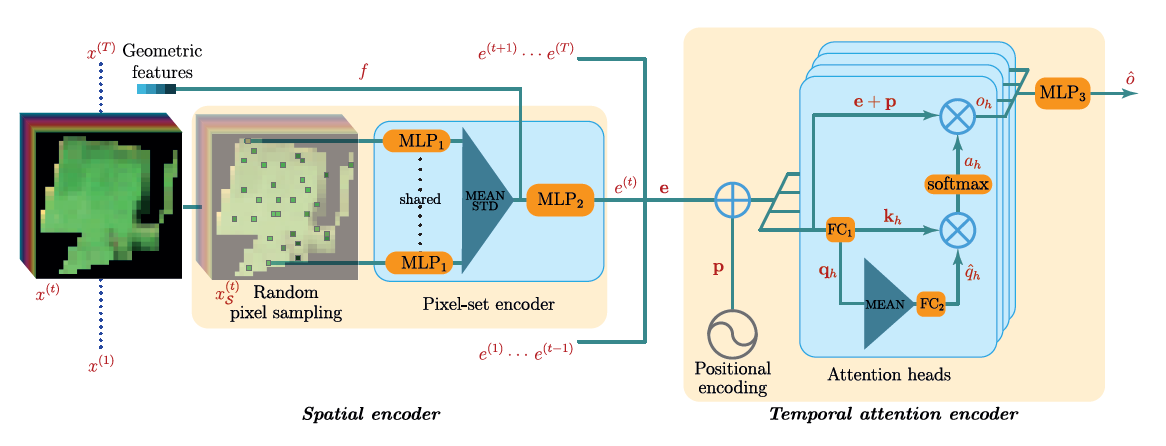

Temporal attention encoder: This component is based on the state-of-the-art transformer used originally for dealing with sequential data. After multi-channel spectral embedding at time t by pse, the temporal attention encoder (tae) tries to find embedding for each parcel's time-series. The authors made the following changes to original transformers:

- The pre-trained word embedding model used in the original mode is replaced by PSE's spectral embedding.
- The positional encoder uses the first obervation or date to calculate number of days to other dates. This helps the model to take in account the variance in temporal observations.
- The goal is to encode the whole time-series into single embedding, rather then generate one for each element of sequence. To achieve this, query tensors generated by the each attention heads are pooled into single master query.

The resulting embedding is processed by an mlp to produice class logits. Spectro-temporal classifier combines PSE and TAE with a final MLP layer to produce class logits.

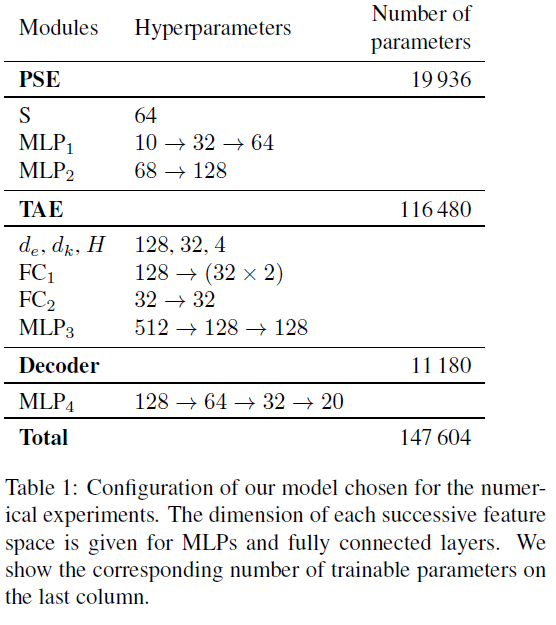